In [19]:
import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

## 0. 파라미터


In [20]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

## 1. 데이터 로드

In [21]:
# 전체 데이터셋 로드
with open('/content/drive/MyDrive/DAT/24-2 팀 프로젝트/LSTM/archive-2/full_format_recipes.json') as json_data :
    recipe_data = json.load(json_data)

#데이터 셋 필터링
filtered_data = [
    'Recipe for ' + x['title'] + '|' + ' '.join(x['directions'])
    for x in recipe_data
    if 'title' in x
    and x['title'] is not None
    and 'directions' in x
    and x['directions'] is not None
]

In [22]:
# 레시피 개수 확인
n_recipes = len(filtered_data)
print(f"{n_recipes}개 레시피 로드")

20111개 레시피 로드


In [23]:
example = filtered_data[9]
print(example)

Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas |Chop enough parsley leaves to measure 1 tablespoon; reserve. Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan, covered, 5 minutes. Meanwhile, sprinkle gelatin over water in a medium bowl and let soften 1 minute. Strain broth through a fine-mesh sieve into bowl with gelatin and stir to dissolve. Season with salt and pepper. Set bowl in an ice bath and cool to room temperature, stirring. Toss ham with reserved parsley and divide among jars. Pour gelatin on top and chill until set, at least 1 hour. Whisk together mayonnaise, mustard, vinegar, 1/4 teaspoon salt, and 1/4 teaspoon pepper in a large bowl. Stir in celery, cornichons, and potatoes. Pulse peas with marjoram, oil, 1/2 teaspoon pepper, and 1/4 teaspoon salt in a food processor to a coarse mash. Layer peas, then potato salad, over ham.


## 2. 데이터 토큰화

In [24]:
# 구두점을 분리하여 별도의 '단어'로 취급
def pad_punctuation(s) :
    s = re.sub(f"([{string.punctuation}])", r' \1 ', s)
    s = re.sub(' +', ' ', s)
    return s

text_data = [pad_punctuation(x) for x in filtered_data]

In [25]:
example_data = text_data[9]
example_data

'Recipe for Ham Persillade with Mustard Potato Salad and Mashed Peas | Chop enough parsley leaves to measure 1 tablespoon ; reserve . Chop remaining leaves and stems and simmer with broth and garlic in a small saucepan , covered , 5 minutes . Meanwhile , sprinkle gelatin over water in a medium bowl and let soften 1 minute . Strain broth through a fine - mesh sieve into bowl with gelatin and stir to dissolve . Season with salt and pepper . Set bowl in an ice bath and cool to room temperature , stirring . Toss ham with reserved parsley and divide among jars . Pour gelatin on top and chill until set , at least 1 hour . Whisk together mayonnaise , mustard , vinegar , 1 / 4 teaspoon salt , and 1 / 4 teaspoon pepper in a large bowl . Stir in celery , cornichons , and potatoes . Pulse peas with marjoram , oil , 1 / 2 teaspoon pepper , and 1 / 4 teaspoon salt in a food processor to a coarse mash . Layer peas , then potato salad , over ham . '

In [26]:
text_ds = tf.data.Dataset.from_tensor_slices(text_data).batch(32).shuffle(1000) # 텐서플로 데이터셋으로 변환

vectorize_layer = layers.TextVectorization(
    standardize = 'lower', # 텍스트 소문자로 바꾸기
    max_tokens = 10000, # 가장 자주 등장하는 10000개의 단어에 정수 부여
    output_mode = 'int',
    output_sequence_length = 200 + 1, # 시퀀스 길이가 201개의 토큰이 되도록 자르거나 패딩
)

vectorize_layer.adapt(text_ds) #TextVectorization 층을 훈련 데이터에 적용
vocab = vectorize_layer.get_vocabulary() # vocab 변수에 단어 토큰의 리스트 저장

In [27]:
# 토큰 : 단어 매핑 샘플 출력하기
for i, word in enumerate(vocab[:10]) :
    print(f"{i}: {word}")

0: 
1: [UNK]
2: .
3: ,
4: and
5: to
6: in
7: the
8: with
9: a


- 0 토큰은 패딩(중지 토큰)에 할당
- 1 토큰은 상위 10000개 단어를 벗어난 알 수 없는 단어에 할당


In [28]:
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[  26   16  557    1    8  298  335  189    4 1054  494   27  332  228
  235  262    5  594   11  133   22  311    2  332   45  262    4  671
    4   70    8  171    4   81    6    9   65   80    3  121    3   59
   12    2  299    3   88  650   20   39    6    9   29   21    4   67
  529   11  164    2  320  171  102    9  374   13  643  306   25   21
    8  650    4   42    5  931    2   63    8   24    4   33    2  114
   21    6  178  181 1245    4   60    5  140  112    3   48    2  117
  557    8  285  235    4  200  292  980    2  107  650   28   72    4
  108   10  114    3   57  204   11  172    2   73  110  482    3  298
    3  190    3   11   23   32  142   24    3    4   11   23   32  142
   33    6    9   30   21    2   42    6  353    3 3224    3    4  150
    2  437  494    8 1281    3   37    3   11   23   15  142   33    3
    4   11   23   32  142   24    6    9  291  188    5    9  412  572
    2  230  494    3   46  335  189    3   20  557    2    0    0    0
    0 

## 3. 훈련 세트 만들기

In [29]:
def prepare_inputs(text) :
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

train_ds = text_ds.map(prepare_inputs) # 레시피 토큰(입력)과 동일하지만 한 토큰 이동된 벡터(타깃)로 구성된 훈련 세트 만들기

## 4. LSTM 만들기

- 입력 : 정수 토큰의 시퀀스
- 출력 : 시퀀스 다음에 10000개 단어의 어휘 사전에서 등장할 수 있는 단어 확률


### 임베딩 층
- 각 정수 토큰을 embedding_size 길이의 벡터로 변환하는 룩업 테이블
- 룩업 벡터는 모델에 의해 학습되는 가중치
- 학습되는 가중치의 개수 = 어휘 사전의 크기에 임베딩 벡터의 차원을 곱한 값
- 모델이 역전파를 통해 업데이트가 가능한 단어 표현을 학습할 수 있어 각 정수 토큰이 연속적인 벡터로 임베딩 됨
- 임베딩 층은 스스로 학습할 수 있기 때문에 성능을 높이기 위해 모델이 토큰의 임베딩 방법을 자유롭게 결정 가능
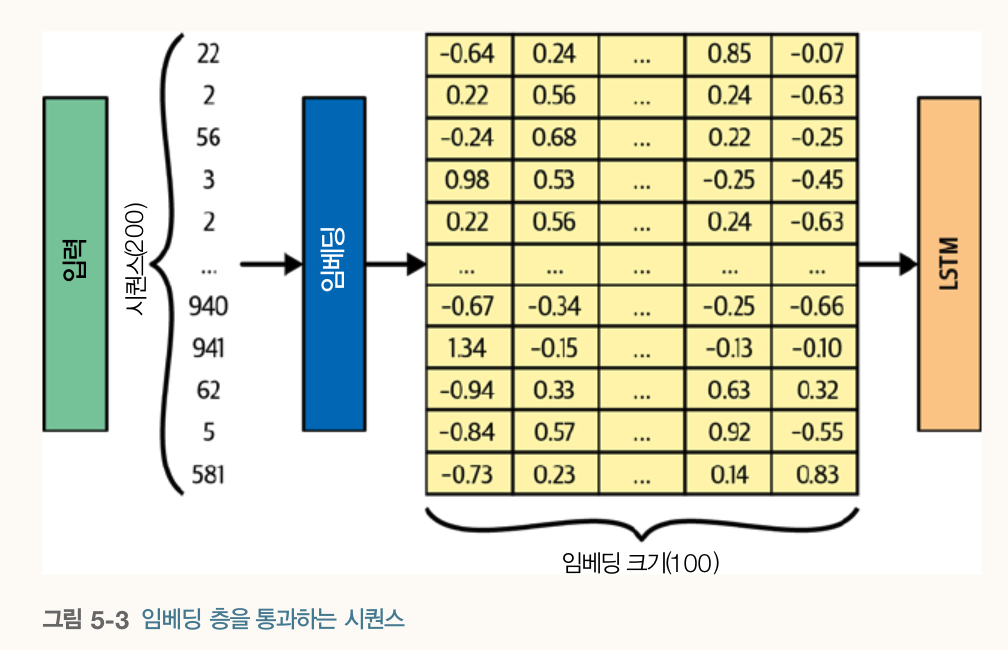

### 순환 층

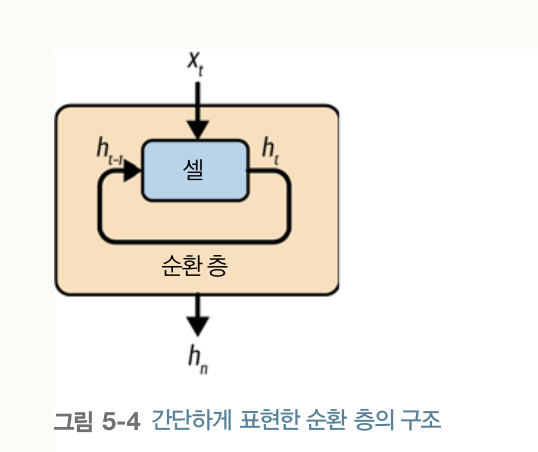
- 일반적인 순환층
- 셀로 구성
- 은닉상태 h은 한 번에 한 타임 스텝씩 시퀀스x의 각 원소를 셀로 전달해 업데이트
- 은닉 상태 : 셀 안에 있는 유닛의 개수와 길이가 동일한 벡터 => 시퀀스에 관한 현재 셀의 지식
- 타임 스텝 t에서 이전 은닉 상태 h(t-1)와 현재 타임 스템 X(t)의 데이터를 사용해 업데이트된 은닉 상태 벡터 h(t)를 만듦
- 시퀀스가 끝나면 최종 은닉 상태 h(n)을 출력하여 다음 층으로 전달

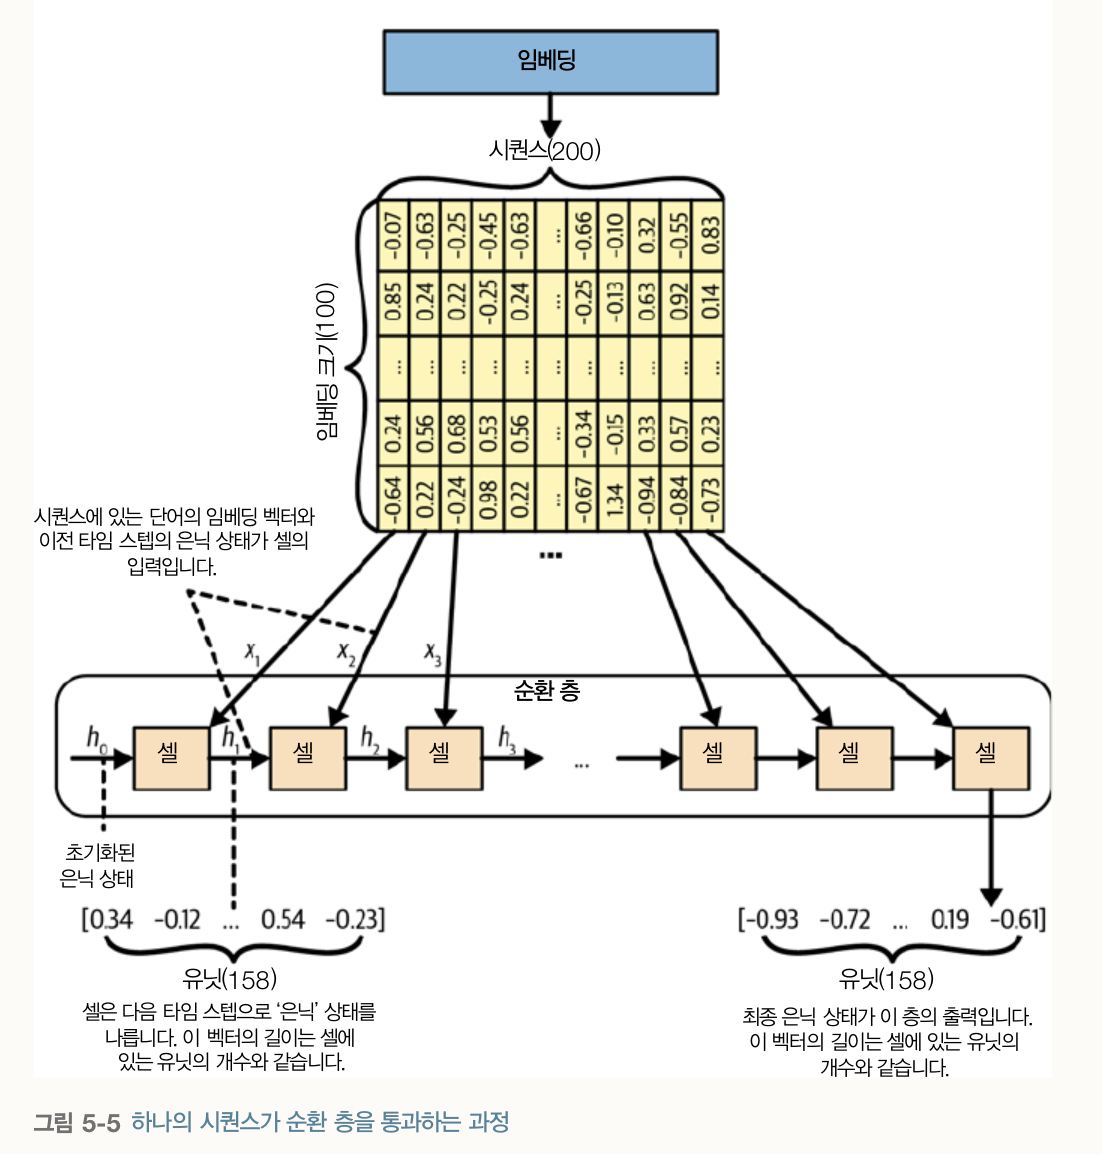

### LSTM 셀
- 이전 은닉 상태와 현재 단어 임베딩이 주어졌을 때 새로운 은닉 상태를 출력
- 하나의 LSTM 셀은 하나의 셀 상태 (C)를 관리
- 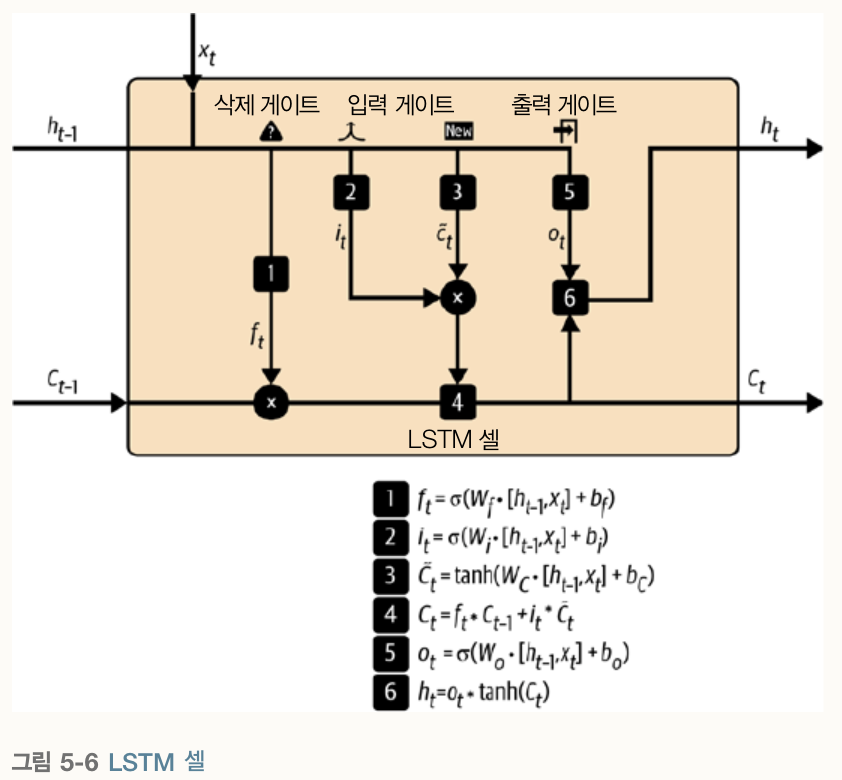


In [2]:
inputs = layers.Input(shape(None,), dtype = "int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DTM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences = True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation = 'softmax')(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

NameError: name 'layers' is not defined

In [3]:
if LOAD_MODEL :
    lstm.models.load_model("./models/lstm", compile = False)

NameError: name 'LOAD_MODEL' is not defined

## 5. LSTM 훈련하기

In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile('adam', loss_fn)

In [ ]:
# TextGenerator 체크포인트 만들기
class TextGenerator(callbacks.Callback) :
    def __init__(self, index_to_word, top_k = 10) :
        self.index_to_word = index_to_word
        self.word_to_index = {
            word : index for index, word in enumerate(index_to_word)
        } # 어휘사전의 역매핑 = 단어에서 토큰으로

    def sample_from(self, probs, temperature) : # temperature 매개변수를 이용해 확률 업데이트
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, strat_prompt, max_tokens, temperature) :
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ] # 시작 프롬포트 : 생성과정을 시작하기 위해 모델에서 제공하는 단어의 문자열 (ex) recipe for
        sample_token = None
        info = []

    while len(start_tokens) < max_tokens and sample_token != 0 : # max_token 길이가 되거나 중지 토큰(0)이ㅣ 나올 때까지 시퀀스 생성
        x = np.array([start_tokens])
        y = self.model.predict(x) # 시퀀스가 다음에 나올 단어의 확률 출력
        sample_token, probs = self.sample_from(y[0][-1], temperature) # 위 확률이 sample_from 메서드로 전달되어 temperature 기반으로 다음 단어 선택
        info.append({'prompt' : start_prompt, 'word_probs':probs})
        start_tokens.append(sample_token) # 생성 과정의 다음 반복을 위해 새로운 단어를 프롬포트 텍스트에 추가
        start_prompt = start_prompt + ' ' + self.index_to_word[sample_token]

    print(f"\n생성된 텍스트 : \n{start_prompt}\n")
    return info

    def on_epoch_end(self, epoch, logs = None) :
        self.generate("recipe for", max_tokens = 100, temperature = 1.0)


In [ ]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = './checkpoint/chekpoint.ckpt',
    save_weights_only = True,
    save_frequ = 'epoch',
    verbose = 0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir = './logs')

# 시작 프롬포트 토큰화
text_generator = TextGenerator(vocab)

In [ ]:
lstm.fit(
    train_ds,
    epochs = EPOCHS,
    callbacks = [model_checkpoint_callback, tensorboard_callback, text_generator],
)

In [ ]:
lstm.save('./models/lstm')

## 6. LSTM 사용해 텍스트 생성하기

In [ ]:
def pritn_probs(info, vocab, top_k = 5):
    for i in info :
        print(f'\n프롬포트: {i['prompt']}')
        word_probs = i['word_probs']
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted) :
            print(f'{vocab[i]}:   \t{np.round(100*p, 2)}%')
        print('------------------\n')

In [ ]:
info = text_generator.generate(
    'recipe for roasted vegetables | chop 1 /', max_tokens=10, temperature=1.0
)

In [ ]:
print_probs(info, vocab)

In [ ]:
info = text_generator.generate(
    'recipe for roasted vegetables | chop 1/', max_tokens=10, temperature= 0.2
)

In [ ]:
print_probs(info, vocab)

In [ ]:
info = text_generator.generate(
    'recipe for chocolate ice cream |', max_tokens = 7, temperature = 1.0
)
print_probs(info, vocab)

In [ ]:
info = text_generator.generate(
    'recipe for chocolate ice cream |', max_tokens=7, temperature=0.2
)
print_probs(info, vocab)

## 4. LSTM 훈련

In [4]:
inputs = layers.Input(shape=(None,), dtype="int32") # input 시퀀스 길이는 가변적이기에 미리 지정하지 않고 None 처리
x = layers.Embedding(10000, 100)(inputs) # Embedding 층은 두 개의 매개변수가 필요 / 어휘사전의 크기(10000), 임베딩 벡터 차원(100)
x = layers.LSTM(128, return_sequences = True)(x) # 은닉 벡터의 차원(128) 설정 / 마지막에 전체 타임 스텝의 은닉 상태 반환하도록 설정
outputs = layers.Dense(10000, activation = 'softmax')(x) # dense 층 : 각 타임 스텝의 은닉 상태를 다음 토큰에 대한 확률 벡터로 변환
lstm = models.Model(inputs, outputs) # Model은 입력 토큰 시퀀스가 주어지면 다음 토큰 예측 / 시퀀스에 있는 각 토큰에 대해 수행

loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile('adam', loss_fn) # SparseCategoricalCrossentropy 손실로 컴파일함 / 레이블이 정수일 때 사용
lstm.fit(train_ds, epochs=25) # 훈련 데이터셋에서 모델 훈련

NameError: name 'layers' is not defined

- temperature 1.0과 0.2를 비교하면 1.0이 분산이 큰 확률분포에서 샘플링하므로 정확도가 떨어진다.
- temperature 1.0이면 다양성이 크고 0.2면 다양성이 작은데, 이 이유는 0.2일 떄 첫 번째 토큰 선택에 훨씬 더 많은 가중치를 주기 때문이다.

## 5. RNN 확장

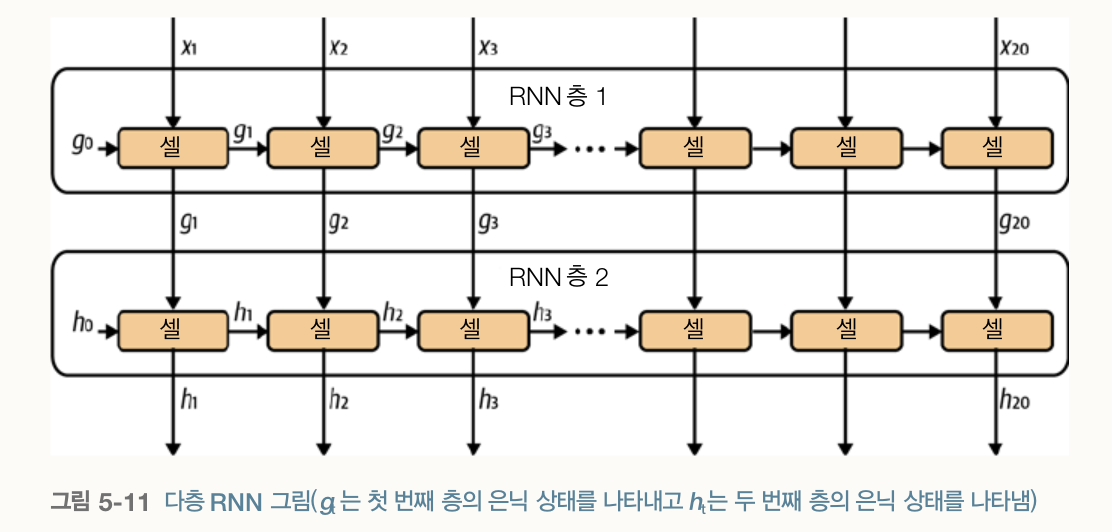

=> 적층 순환 네트워크

In [ ]:
# 적층 LSTM 만들기

text_in = layers.Input(shape = (None,))
embedding = layers.Embedding(total_words, embedding_size)(text_in)
x = layers.LSTM(n_units, return_Sequences = True)(x)
x = layers.LSTM(n_units, return_sequences = True)(x)
probailites = layers.Dense(total_words, activation = 'softmax')(x)
model = models.Model(text_in, probabilites)

## GRU 층
- LSTM과 주요 차이점
1. 삭제 게이트와 입력 데이트가 리셋 게이트와 업데이트 게이트로 바뀜
2. 셀 상태와 출력 게이트가 없음. 셀은 은닉 상태만 출력
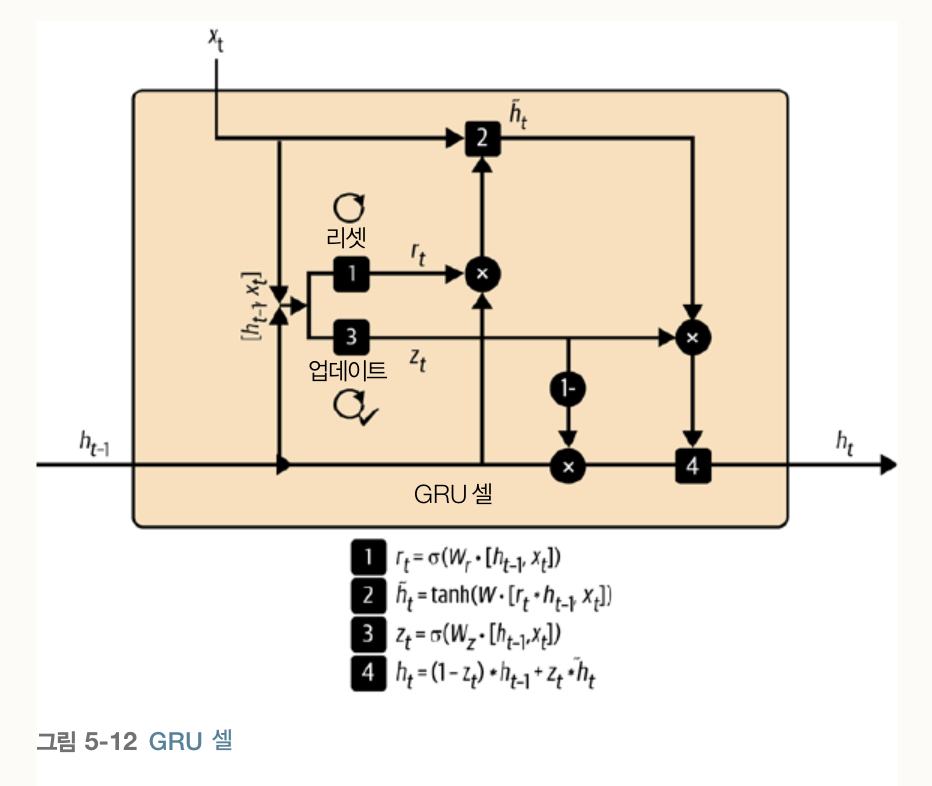

## 양방향 셀

In [1]:
# 양방향 GRU 층 만들기
layer = layers.Bidirectional(layers.GRU(100))

NameError: name 'layers' is not defined